## pymc3 + ArviZ

> PyMC3 is a probabilistic programming package for Python that allows users to fit Bayesian models using a variety of numerical methods, most notably Markov chain Monte Carlo (MCMC) and variational inference (VI). Its flexibility and extensibility make it applicable to a large suite of problems. Along with core model specification and fitting functionality, PyMC3 includes functionality for summarizing output and for model diagnostics.

> ArviZ is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, data storage, sample diagnostics, model checking, and comparison.
> The goal is to provide backend-agnostic tools for diagnostics and visualizations of Bayesian inference in Python, by first converting inference data into xarray objects.



In [136]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import seaborn as sns

## Model basics

All models are derived from the `Model()` class, unlike what we have seen previously PyMC makes heavy use of Python's context manager using the `with` statement to add model components to a model.


In [2]:
with pm.Model() as norm:
    x = pm.Normal("x", mu=0, sigma=1)

In [3]:
x

x ~ Normal(0, 1)

In [4]:
with norm:
    y = pm.Normal("y", mu=x, sigma=1, shape=3)

In [5]:
y

y ~ Normal(x, 1)

In [6]:
norm

x ~ Normal(0, 1)
y ~ Normal(x, 1)

## Random Variables

`pm.Normal()` is an example of a PyMC distribution, which are used to construct models, these are implemented using the `FreeRV` class which is used for all of the builtin distributions (and can be used to create custom distributions). Some useful methods and attributes,



In [8]:
norm.named_vars

{'x': x ~ Normal(0, 1), 'y': y ~ Normal(x, 1)}

In [9]:
norm.x.shape

TensorConstant{[]}

In [10]:
norm.x.size

Prod{scalar_op=<pytensor.scalar.basic.Mul object at 0x1093ff010>, axis=None, dtype='int64', acc_dtype='int64', no_zeros_in_input=False}.0

## Variable heirarchy

Note that we defined $y|x \sim \mathcal{N}(x, 1)$, so what is happening when we use `pm.draw(y)`?


In [11]:
pm.draw(y)

array([-2.25561366, -2.48137017, -1.11619696])

In [19]:
obs = pm.draw(y, draws=1000)
np.mean(obs)

-0.05421584048202654

In [20]:
np.var(obs)

2.032977870973115

In [21]:
np.std(obs)

1.4258253297557577

## Beta-Binomial model

We will now build a basic model where we know what the solution should look like and compare the results.

In [22]:
with pm.Model() as beta_binom:
    p = pm.Beta("p", alpha=10, beta=10)
    x = pm.Binomial("x", n=20, p=p, observed=5)

In [23]:
p

p ~ Beta(10, 10)

In [24]:
x

x ~ Binomial(20, p)

In [25]:
with beta_binom:
    trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.
/Users/lemerleau/miniforge3/envs/fmi08icds/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


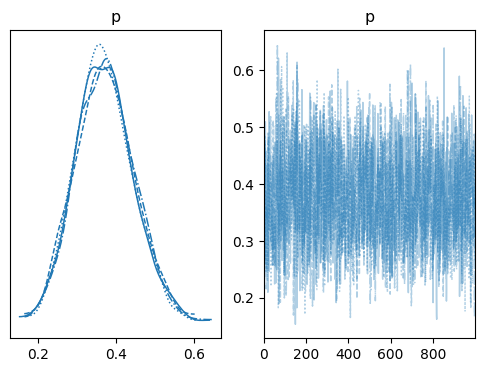

In [28]:
ax = az.plot_trace(trace, figsize=(6,4))
plt.show()

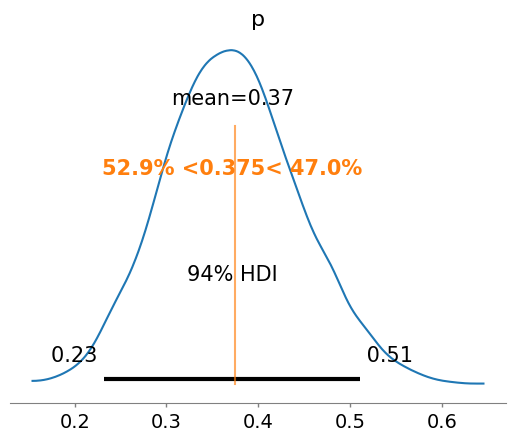

In [29]:
ax = az.plot_posterior(trace, ref_val=[15/40])
plt.show()

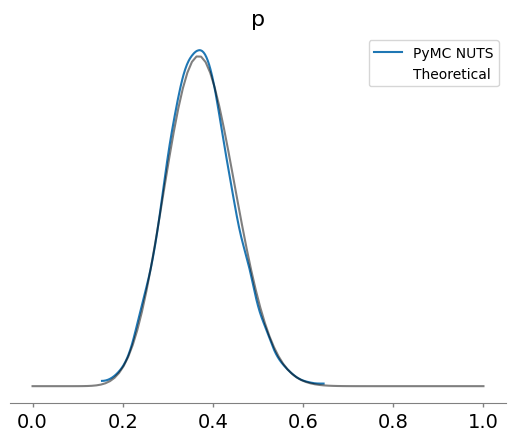

In [32]:
p = np.linspace(0, 1, 100)
post_beta = scipy.stats.beta.pdf(p,15,25)
ax = az.plot_posterior(trace, hdi_prob="hide", point_estimate=None)
plt.plot(p,post_beta, "-k", alpha=0.5, label="Theoretical")
plt.legend(['PyMC NUTS', 'Theoretical'])
plt.show()

## InferenceData results

In [33]:
print(trace)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [34]:
print(type(trace))

<class 'arviz.data.inference_data.InferenceData'>


> **xarray: N-D labeled arrays and datasets in Python**
>
> xarray (formerly xray) is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun!
>
>Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures.
>
Xarray is inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

See [here](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html) for more details on xarray + InferenceData
]


In [35]:
print(trace.posterior)

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    p        (chain, draw) float64 0.5068 0.4518 0.3853 ... 0.166 0.3242 0.3242
Attributes:
    created_at:                 2023-07-06T22:30:53.141879
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.0
    sampling_time:              0.44486498832702637
    tuning_steps:               1000


In [36]:
print(trace.posterior["p"].shape)

(4, 1000)


In [37]:
print(trace.sel(chain=0).posterior["p"].shape)

(1000,)


In [38]:
print(trace.sel(draw=slice(500, None, 10)).posterior["p"].shape)

(4, 50)


## As DataFrame

Posterior values, or subsets, can be converted to DataFrames via the `to_dataframe()` method

In [40]:
trace.posterior.to_dataframe()

p
chain draw          
0     0     0.506797
      1     0.451803
      2     0.385329
      3     0.507061
      4     0.374281
...              ...
3     995   0.284547
      996   0.202096
      997   0.165955
      998   0.324233
      999   0.324233

[4000 rows x 1 columns]

In [41]:
trace.posterior["p"][0,:].to_dataframe()

,chain,p
draw,,
0,0,0.506797
1,0,0.451803
2,0,0.385329
3,0,0.507061
4,0,0.374281
...,...,...
995,0,0.356664
996,0,0.356664
997,0,0.397380


## MultiTrace results

In [42]:
with beta_binom:
    mt = pm.sample(random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [43]:
mt

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [44]:
type(mt)

arviz.data.inference_data.InferenceData

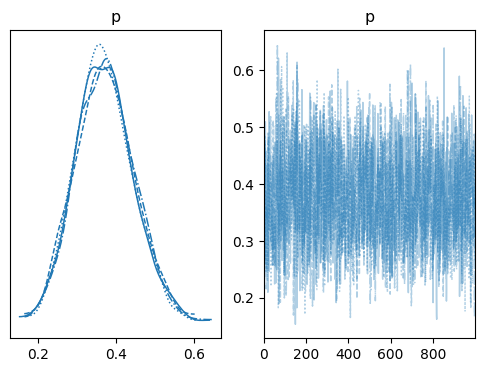

In [45]:
ax = az.plot_trace(mt, figsize=(6,4))

In [46]:
plt.show()

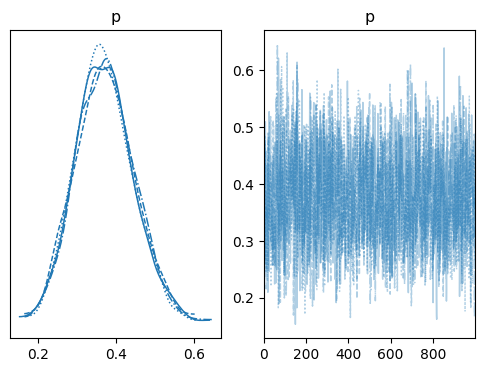

In [47]:
with beta_binom:
  ax = az.plot_trace(mt, figsize=(6,4))
plt.show()

In [53]:
mt["posterior"]

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    p        (chain, draw) float64 0.5068 0.4518 0.3853 ... 0.166 0.3242 0.3242
Attributes:
    created_at:                 2023-07-06T22:34:34.774823
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.6.0
    sampling_time:              0.36585235595703125
    tuning_steps:               1000

In [60]:
mt['posterior'].p

<xarray.DataArray 'p' (chain: 4, draw: 1000)>
array([[0.5067974 , 0.45180328, 0.3853287 , ..., 0.39738044, 0.40186466,
        0.40186466],
       [0.40876425, 0.34070911, 0.31866792, ..., 0.30590217, 0.36323356,
        0.34164104],
       [0.28706004, 0.31579963, 0.35558303, ..., 0.41828395, 0.27331837,
        0.26606297],
       [0.30477692, 0.30477692, 0.45784506, ..., 0.16595488, 0.32423301,
        0.32423301]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [61]:
mt['posterior'].p.shape

(4, 1000)

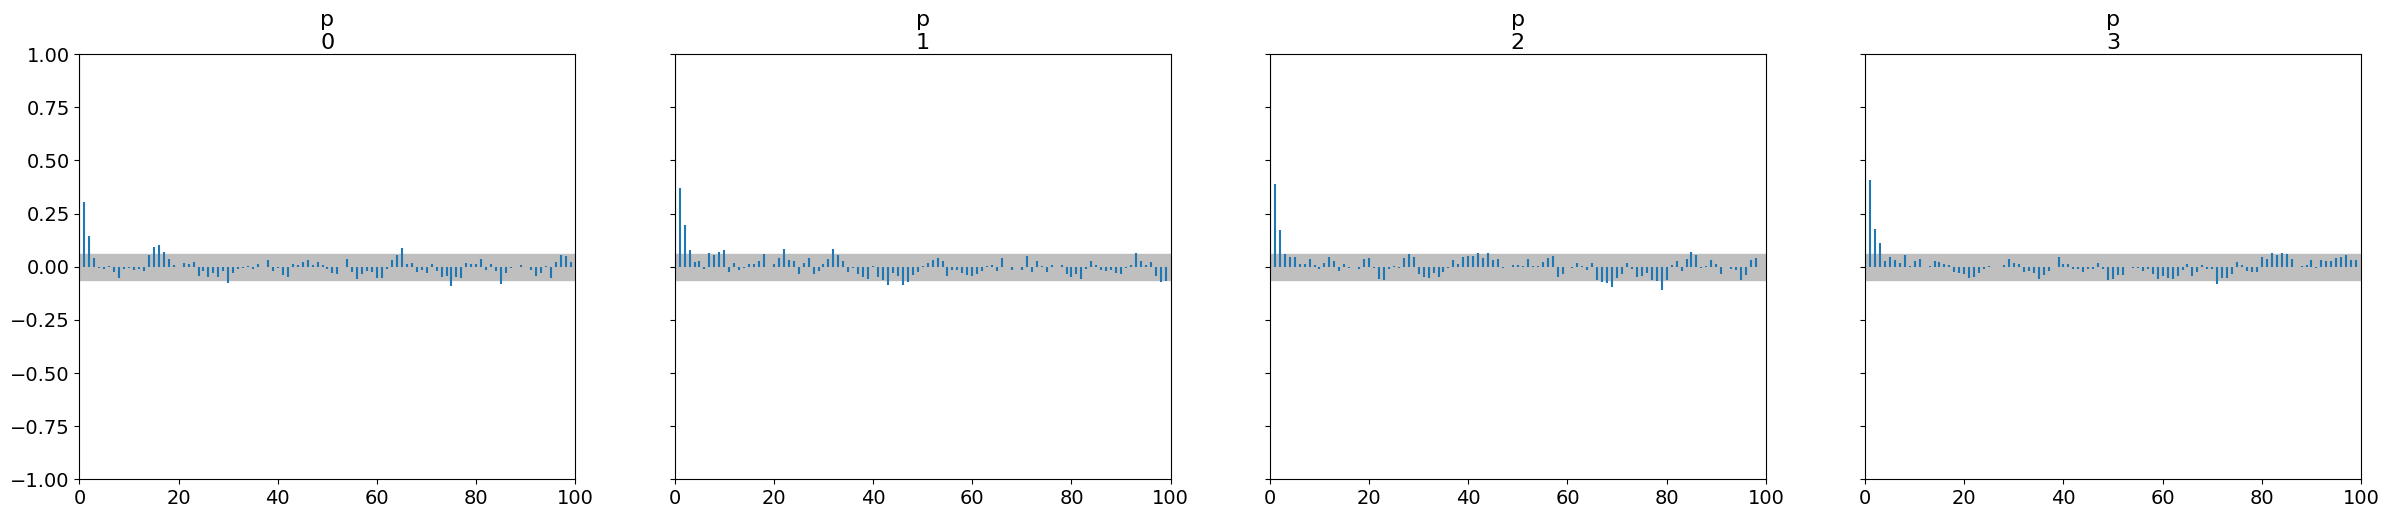

In [76]:
ax = az.plot_autocorr(trace)
plt.show()

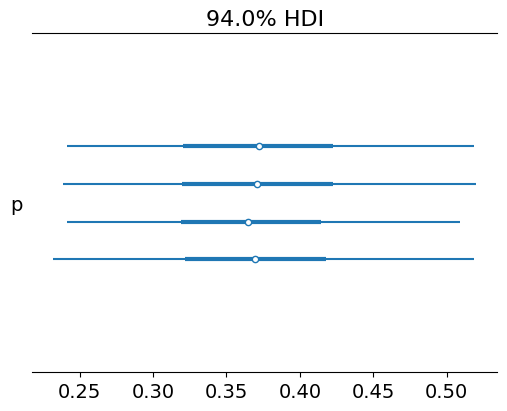

In [77]:
ax = az.plot_forest(trace)
plt.show()

## Other useful diagnostics

Standard MCMC diagnostic statistics are available via `summary()` from ArviZ

In [78]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.372,0.074,0.232,0.511,0.002,0.001,1615.0,2222.0,1.0


In [79]:
print(az.ess(trace, method="bulk"))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 1.615e+03


In [80]:
print(az.ess(trace, method="tail"))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 2.222e+03


In [81]:
print(az.rhat(trace))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 1.002


In [82]:
print(az.mcse(trace))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p        float64 0.001844


## Demo 1 - Linear regression

Given the below data, we will fit a linear regression model to the following synthetic data,

In [83]:
np.random.seed(1234)
n = 11
m = 6
b = 2
x = np.linspace(0, 1, n)
y = m*x + b + np.random.randn(n)

In [90]:
with pm.Model() as lm:
    m = pm.Normal('m', mu=0, sigma=50)
    b = pm.Normal('b', mu=0, sigma=50)
    sigma = pm.HalfNormal('sigma', sigma=5)
    likelihood = pm.Normal('y', mu=m*x + b, tau=sigma, observed=y)
    trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [91]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,5.609,1.182,3.454,7.760,0.033,0.026,1422.0,1621.0,1.00
b,2.166,0.694,0.925,3.446,0.019,0.014,1375.0,1708.0,1.01
sigma,0.881,0.375,0.227,1.574,0.009,0.007,1505.0,1512.0,1.00


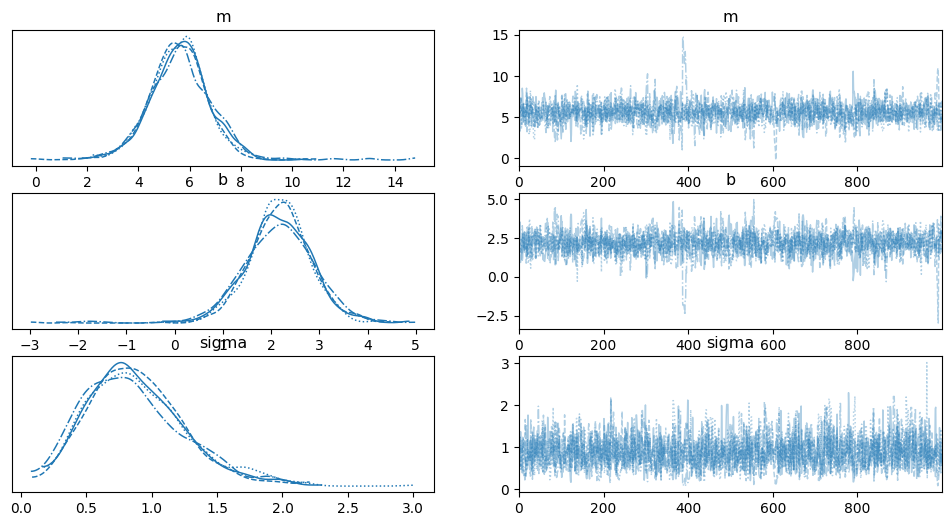

In [92]:
ax = az.plot_trace(trace)
plt.show()

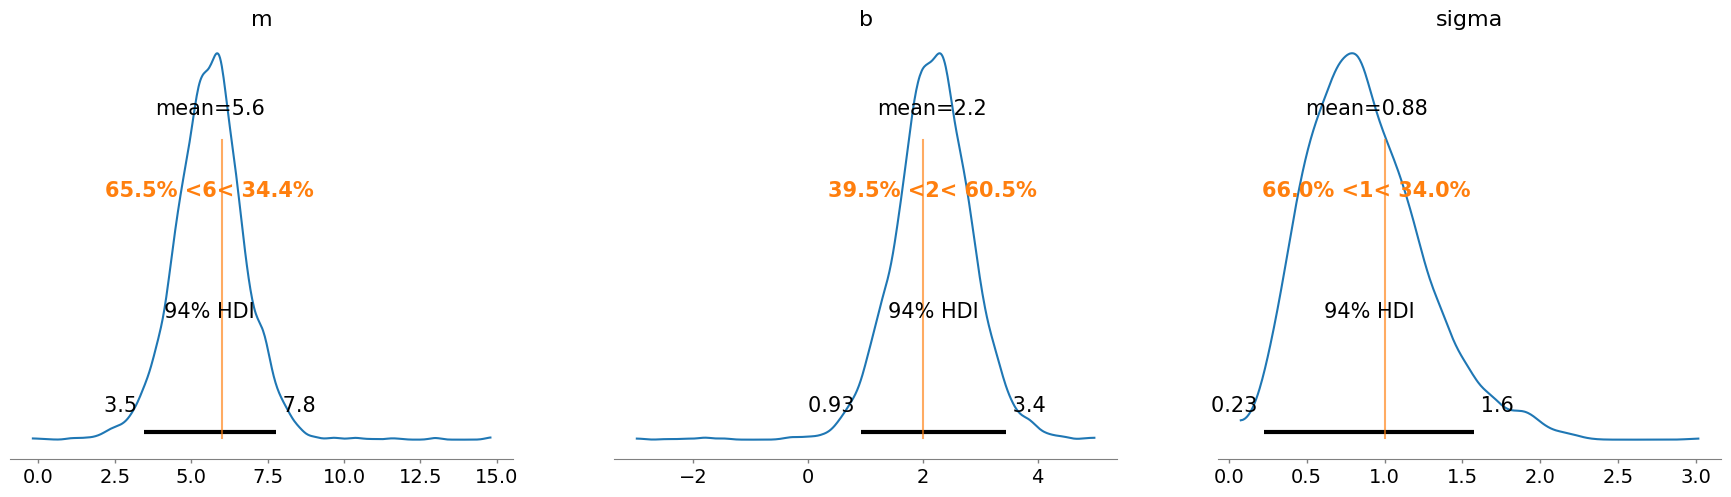

In [93]:
ax = az.plot_posterior(trace, ref_val=[6,2,1])
plt.show()

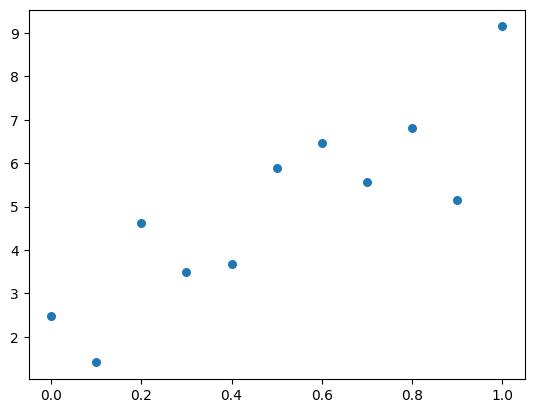

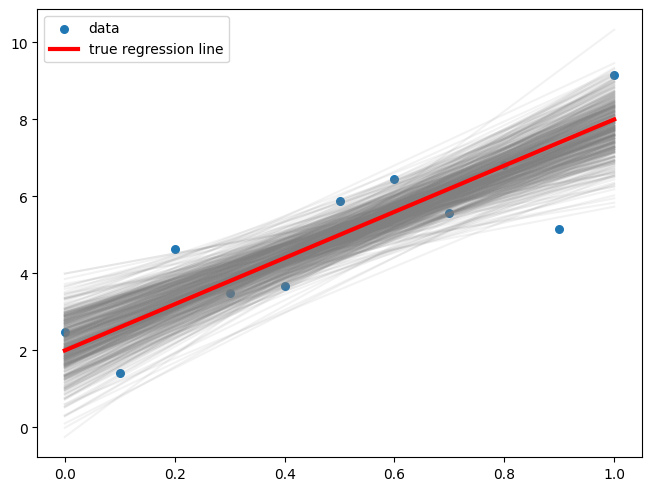

In [94]:
plt.scatter(x, y, s=30, label='data')
post_m = trace.posterior['m'][0, -500:]
post_b = trace.posterior['b'][0, -500:]
plt.figure(layout="constrained")
plt.scatter(x, y, s=30, label='data')
for m, b in zip(post_m.values, post_b.values):
    plt.plot(x, m*x + b, c='gray', alpha=0.1)
plt.plot(x, 6*x + 2, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
plt.show()

## Posterior Predictive

In [113]:
with lm:
    pp = pm.sample_posterior_predictive(trace, sample_dims=["chain", "draw"])

Sampling: [y]


In [105]:
pp.keys()

KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)

In [114]:
pp["posterior_predictive"].y.

(4, 1000, 11)

ValueError: x and y can be no greater than 2D, but have shapes (11,) and (11, 1000, 4)

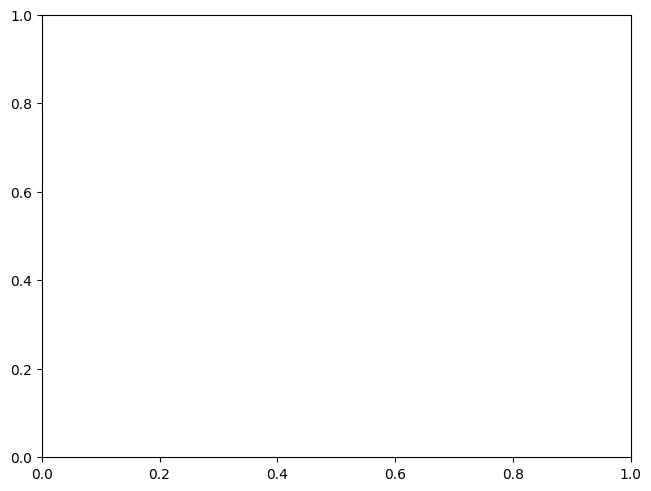

In [108]:
plt.figure(layout="constrained")
plt.plot(x, pp['posterior_predictive'].y.T, c="grey", alpha=0.1)
plt.scatter(x, y, s=30, label='data')
plt.show()

## Model revision

In [119]:
with pm.Model() as lm2:
    m = pm.Normal('m', mu=0, sigma=50)
    b = pm.Normal('b', mu=0, sigma=50)
    sigma = pm.HalfNormal('sigma', sigma=5)
    y_est = pm.Deterministic("y_est", m*x + b)
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
    trace = pm.sample(return_inferencedata=True, random_seed=1234)
    pp = pm.sample_posterior_predictive(trace, var_names=["y_est"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: []


<Figure size 640x480 with 0 Axes>

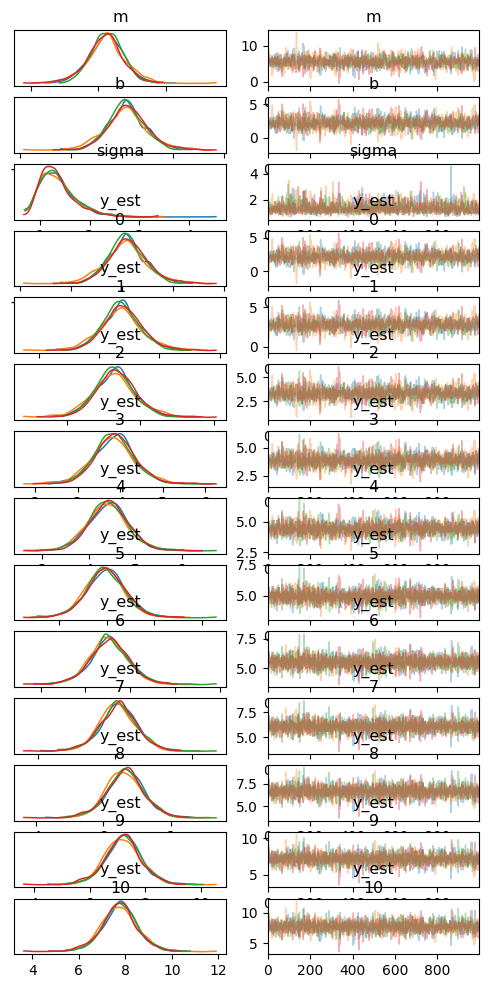

In [120]:
plt.figure(layout="constrained")
ax = az.plot_trace(trace, compact=False, figsize=(6,12))
plt.show()

In [121]:
pp['y_est'].shape

plt.figure(layout="constrained")
plt.plot(x, pp['y_est'].T, c="grey", alpha=0.1)
plt.scatter(x, y, s=30, label='data')
plt.show()

KeyError: 'y_est'

## Demo 2 - Bayesian Lasso

In [122]:
n = 50
k = 100
np.random.seed(1234)
X = np.random.normal(size=(n, k))
beta = np.zeros(shape=k)
beta[[10,30,50,70]] =  10
beta[[20,40,60,80]] = -10
y = X @ beta + np.random.normal(size=n)

In [123]:
with pm.Model() as bayes_lasso:
    b = pm.Laplace("beta", 0, 1, shape=k)#lam*tau, shape=k)
    y_est = X @ b
    s = pm.HalfNormal('sigma', sigma=1)
    likelihood = pm.Normal("y", mu=y_est, sigma=s, observed=y)
    trace = pm.sample(return_inferencedata=True, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 239 divergences after tuning. Increase `target_accept` or reparameterize.


In [126]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.067,0.785,-1.402,1.716,0.011,0.018,4345.0,1972.0,1.02
beta[1],0.308,0.829,-1.179,1.710,0.152,0.119,38.0,533.0,1.07
beta[2],-0.045,0.783,-1.634,1.478,0.012,0.015,4101.0,2327.0,1.02
beta[3],-0.215,0.804,-1.865,1.157,0.075,0.053,95.0,2069.0,1.03
beta[4],0.063,0.775,-1.508,1.570,0.012,0.013,4381.0,2580.0,1.11
...,...,...,...,...,...,...,...,...,...
beta[96],0.173,0.774,-1.322,1.427,0.136,0.097,38.0,2541.0,1.07
beta[97],-0.139,0.721,-1.532,1.351,0.011,0.014,3961.0,2368.0,1.11
beta[98],0.244,0.708,-1.038,1.689,0.028,0.020,570.0,2040.0,1.01
beta[99],-0.277,0.750,-1.850,1.061,0.020,0.016,1298.0,1953.0,1.01


In [125]:
az.summary(trace).iloc[[0,10,20,30,40,50,60,70,80,100]]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.067,0.785,-1.402,1.716,0.011,0.018,4345.0,1972.0,1.02
beta[10],8.306,1.184,6.066,10.577,0.025,0.018,2301.0,2176.0,1.04
beta[20],-8.298,1.253,-10.672,-5.908,0.029,0.021,1860.0,2316.0,1.01
beta[30],8.673,0.979,6.683,10.340,0.050,0.035,551.0,2361.0,1.01
beta[40],-8.781,1.517,-11.710,-5.931,0.031,0.022,2408.0,2496.0,1.12
beta[50],9.076,0.981,7.097,10.773,0.041,0.029,1055.0,2812.0,1.01
beta[60],-9.313,1.133,-11.377,-7.166,0.133,0.098,69.0,2392.0,1.04
beta[70],8.636,1.228,6.214,10.546,0.167,0.125,53.0,2107.0,1.05
beta[80],-9.984,0.888,-11.761,-8.366,0.017,0.012,2629.0,2425.0,1.05
sigma,0.825,0.522,0.171,1.790,0.129,0.093,10.0,8.0,1.30


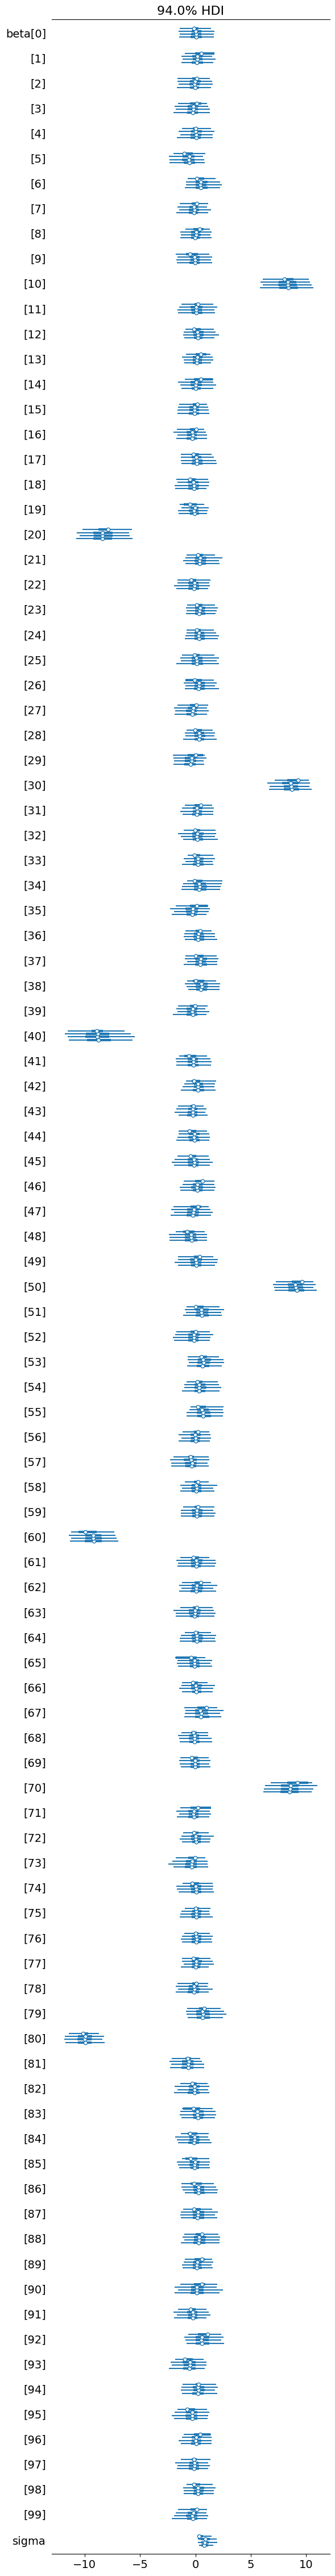

In [127]:
ax = az.plot_forest(trace)
plt.tight_layout()
plt.show()

In [128]:
def plot_slope(trace, prior="beta", chain=0):
    post = (trace.posterior[prior]
          .to_dataframe()
          .reset_index()
          .query("chain == 0")
         )
    sns.catplot(x="beta_dim_0", y="beta", data=post, kind="boxen", linewidth=0, color='blue', aspect=2, showfliers=False)
    plt.tight_layout()
    plt.show()

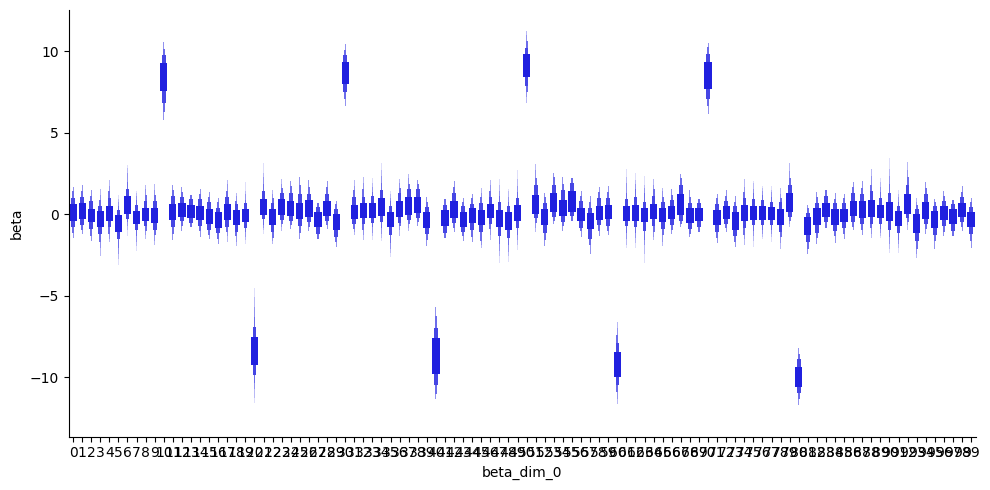

In [131]:
plot_slope(trace)

## Weakly informative prior 


In [133]:
with pm.Model() as bayes_weak:
    b = pm.Normal("beta", 0, 10, shape=k)
    y_est = X @ b
    s = pm.HalfNormal('sigma', sigma=2)
    likelihood = pm.Normal("y", mu=y_est, sigma=s, observed=y)
    trace = pm.sample(return_inferencedata=True, random_seed=12345)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.


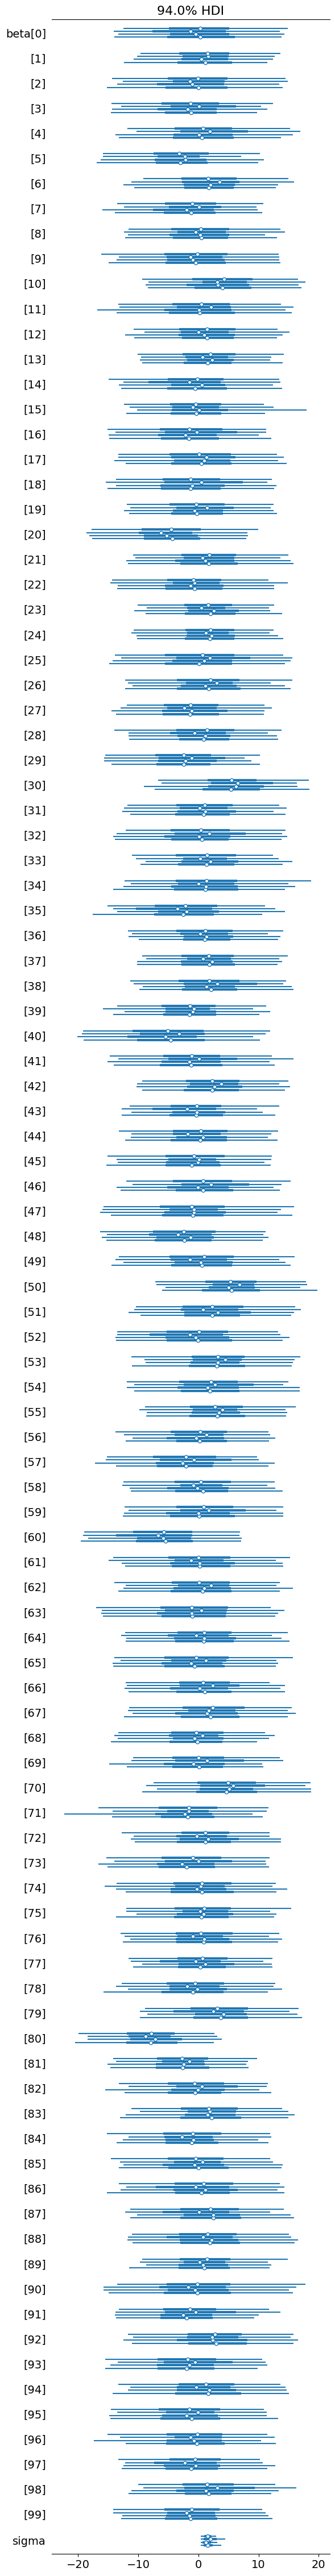

In [134]:
ax = az.plot_forest(trace)
plt.tight_layout()
plt.show()

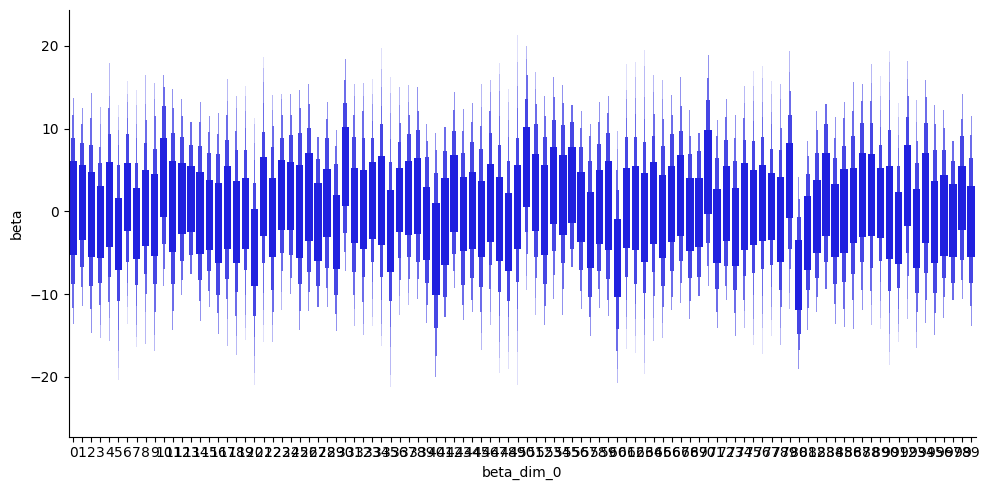

In [135]:
plot_slope(trace)

## End notebook.